# ConvNN Insights

Let's see some insights for Conv NNs.

We will see:
1. Unary Convolution
2. DepthWise separable Convolution DSC
3. Batch Normalization
4. Residual Learning 
5. Transposed Convolution
6. Dilated Convolution 

## UNARY CONVOLUTION

Unary convolution is simply a normal Conv layer in which the kernel spatial dimensions are both unitary: $k_1=1, k_2=1$. (Typically, also the strides are unitary: $S_1=1, S_2=1$).

Such convolution is interesting for several reasons.

In [ ]:
x = Conv2D(filters=..., kernel_size=(1,1), strides=(1,1), padding='same')(x)

The number of kernels is the number of output channels: $c_{out}$. Each kernel is unitary: dimensions $1, 1, c_{in}$.

**Convolution only across the channels**

When a unitary kernel $1, 1, c_{in}$ is applied, the values are not aggregated across different pixels, but they are aggregated only across different channels. Indeed, a kernel of this layer has dimensions $1,1,c_{in}$: therefore, it is not able to aggregate values from different pixels, but it aggregates values only from different channels. In other words, the convolution is applied only across the channels dimension, and not across the spatial dimensions.

Instead, a classic Conv layer aggregates values from both different pixels and different channels at the same time. A classic Conv layer applies the convolution both across the spatial dimensions and across the channels dimension at the same time. (A kernel has dimensions $k_1, k_2, c_{in}$).

**The spatial dimensions are not modified**

The unary conv does not change the spatial dimensions: the output spatial dimensions are equal to the input spatial dimensions. $w_{in},h_{in} \implies w_{in},h_{in}$.

**Changing the number of channels**

The aim of unary convolution is simply to change the number of channels. It changes the channels dimension from $c_{in}$ to $c_{out}$. $c_{in} \implies c_{out}$.

The typical usage is to enlarge the channels dimension. But, in some cases, can be useful to decrease the channels dim ension.

## DEPTHWISE SEPARABLE CONVOLUTION DSC

DSC is another kind of Conv layer. So, we have the classic Conv layer (i.e. CC layer) and the DSC layer.

**Unary convolutions and Inception hypothesis**

As we have just seen, unary Conv performs convolution only across the channels, and not across the spatial dimensions. While the classic convolution performs both.

This can be generalized, into the Inception hypothesis (from the Inception NN). We could split the computation of a classic convolution into two processes.
1. First we apply the convolution only across the spatial dimensions.
2. Then we apply the convolution only across the channels dimension.

This idea brings to the DSC layer.

**CC layer**

The interface is the following:
- Input $w_{in},h_{in},c_{in}$
- Output $w_{out},h_{out},c_{out}$

It applies the convolution both across the spatial dimensions and across the channels at the same time.

**DSC layer**

The interface is the same:
- Input $w_{in},h_{in},c_{in}$
- Output $w_{out},h_{out},c_{out}$

The difference is that it applies first the convolution only across the spatial dimensions, and then it applies the convolution only across the channels.

1. Step 1. We have a single 3D kernel $k_1,k_2,c_{in}$. Which can be seen as $c_{in}$ 2D kernels $k_1,k_2$. Each 2D kernel is applied on the corresponding input channel, producing a feature map $w_{out}, h_{out}$. So, we get $c_{in}$ feature maps: output dimensions $w_{out},h_{out},c_{in}$.

2. Step 2. We have $c_{in}$ feature maps/channels. We want to transform that to $c_{out}$ channels, without modifying the spatial dimensions. So, we apply the classic unary convolution: we have $c_{out}$ 3D unitary kernels of dimensions $1, 1, c_{in}$. Final output dimensions: $w_{out},h_{out},c_{out}$.

**Keras implementation**

In keras, it is very easy to define a DSC layer.

For doing the step 1, we use a new layer: `DepthwiseConv2D`.

In [ ]:
from tensorflow.keras.layers import DepthwiseConv2D

In [ ]:
x = DepthwiseConv2D(kernel_size=..., strides=..., padding=...)(x)

For doing the step 2, we simply do a classic unary convolution.

In [ ]:
x = Conv2D(filters=..., kernel_size=(1,1), strides=(1,1), padding='same')(x)

**Comparison DSC - CC**

A DSC layer has less parameters than CC. Indeed, DSC layer has $k_1*k_2*c_{in}+c_{in}*c_{out}$ parameters, while CC layer has $k_1*k_2*c_{in}*c_{out}$. (We are not considering the biases).

Therefore:
- DSC is less expressive and powerful (there are transformations which can be computed by CC but not by DSC)
- DSC is simpler, lighter and faster

If out transformation of interest can be computed using DSC, it is better to use DSC since it is simpler. Otherwise, we are recquired to use CC.

## BATCH NORMALIZATION

The normalization of the input is a typical operation done in ML. Most famous normalization: transforming the values to have $0$ mean and variance $1$. This is done by the operation $(x-\mu)/\sigma$, where $x$ is the input, $\mu$ the mean of the input and $\sigma$ the standard deviation.

Why don't apply this normalization also on the input of a NN layer? We normalize the input $x$ of out NN layer: this is done by putting a **batch normalization layer** before that NN layer. The input $x$ that we want to normalize is (typically) the output of another NN layer.

### Introduction

**Problem**

However, normalizaing an input $x$ of a layer is not as simple as normalizing the actual input in ML. In particular, computing $\mu$ and $\sigma$ is more difficult. And this because we are in a training process:
- The input values $x$ are given in a batch, which change at each step;
- The weigths change at each step, and so the input values $x$ are computed in a different way at each step ($x$ is the output of the previous NN layer).

It is difficult to comput $\mu$ and $\sigma$ with data which are so fluent.

**Batch normalization layer**

For computing $\mu$ and $\sigma$ of the input values $x$ we do a moving average along the training process.
- Training step, batch of data -> Compute $\mu$, $\sigma$
- New training step, new batch of data -> Compute new $\mu^{'}$, $\sigma^{'}$ and aggregate these with the last $\mu$, $\sigma$. Basically, we update $\mu$, $\sigma$ with $\mu^{'}$, $\sigma^{'}$

And so on.

So,  $\mu$ and $\sigma$ are computed dynamically, by means of a moving average. These $\mu$, $\sigma$ will be then used during inference.

It is called "batch normalization" because, at each training step, we are computing $\mu$, $\sigma$ by averaging on the given batch.

### More in depth

**New mean $\gamma$ and new std $\beta$**

So, we are normalizing the input $x$ of our NN layer. But, actually, we don't know if this is useful. It could be that it would be better without normalization. So, the idea is that batch normalization has also the possibility to undo this normalization.

This "undo" is done by learning a new mean $\gamma$ and new std $\beta$, and by rescaling with these quantities.

So, the actual input $x$ is transformed in this way: $(x-\mu)/\sigma*\beta+\gamma$.

**Batch normalization: on the whole**

So, batch normalization operates in the following way.

Training step. Batch of input data $x$.
1. The $\mu^{'}$, $\sigma^{'}$ are computed over the batch $x$. We update the current $\mu$, $\sigma$ with $\mu^{'}$, $\sigma^{'}$.
2. We normalize the input data $x$, using $\mu^{'}$, $\sigma^{'}$: $(x-\mu^{'})/\sigma^{'}$.
3. Finally, we rescale another time, using $\gamma$, $\beta$: $(x-\mu^{'})/\sigma^{'}*\beta+\gamma$. These are the actual input values for the next layer.

**Batch normalization: parameters**

On the whole, there are $4$ parameters: $\mu, \sigma, \gamma, \beta$. But huge difference $\mu, \sigma$ between and $\gamma, \beta$.
- $\mu, \sigma$ They are computed step by step during the training process. Non-trainable para,eters.
- $\gamma, \beta$ They are learnt during the training process, with the backward passes (like the weigths of the NN).

**Batch normalization: it operates in a per-channel base**

Traning step, with batch $x$. $N$ individuals. Each individual has dimensions $w_{in}, h_{in}, c_{in}$.

The batch normalization operates in a per-channel base. Which means that each channel has its own parameters $\mu, \sigma, \gamma, \beta$, and it updates them indipendently from the other channels.

Basically, what we have said since now about batch normalization, is applied in each channel separately and independently.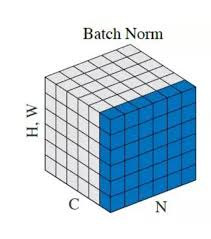

There are also other kinds of normalization, which operate differently.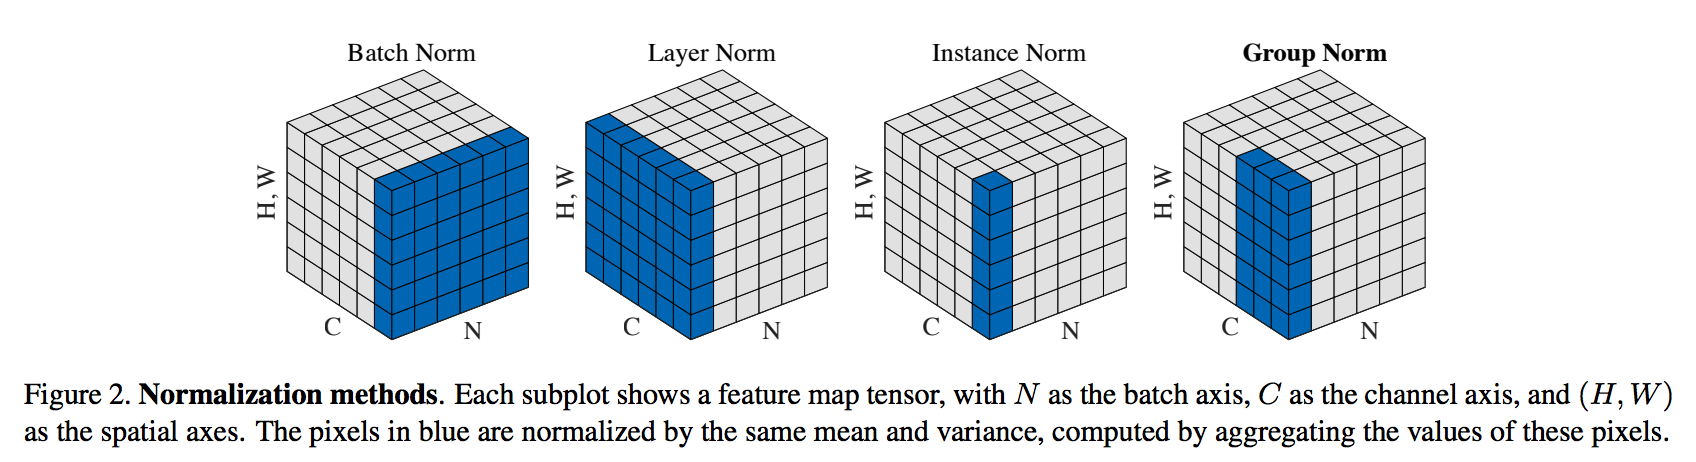

**Batch normalization: total number of parameters**

The total number of parameters is $4*c_{in}$, since each channel has its own parameters $\mu, \sigma, \gamma, \beta$. 

$2*c_{in}$ are non-trainable ($\mu, \sigma$), $2*c_{in}$ are trainable ($\gamma, \beta$).

### Batch normalization in keras

https://keras.io/api/layers/normalization_layers/batch_normalization/

In [ ]:
from tensorflow.keras.layers import BatchNormalization

In [ ]:
x = BatchNormalization()(x)

### Insight: activation function and batch normalization

So, we put the Batch normalization layer between two NN layers. The previous NN layer can contain an activation function. It is better to place the Batch normalization before or after the application of the activation function? Typically, it is better to place after the activation function.

So, it is better this:

In [ ]:
x = Conv2D(...)(x)
x = BatchNormalization()(x)
x = ReLU()(x)

than this:

In [ ]:
x = Conv2D(..., activation='relu')(x)
x = BatchNormalization()(x)

## RESIDUAL LEARNING

https://towardsdatascience.com/building-a-resnet-in-keras-e8f1322a49ba

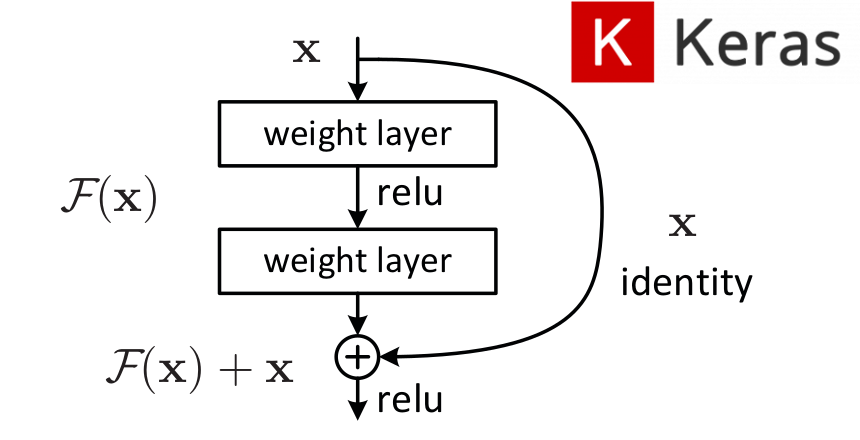
In principle, neural networks should get better results as they have more layers. A deeper network can learn anything a shallower version of itself can, plus (possibly) more than that. If, for a given dataset, there are no more things a network can learn by adding more layers to it, then it can just learn the identity mapping for those additional layers. In this way, it preserves the information in the previous layers and can not do worse than shallower ones. A network should be able to learn at least the identity mapping if it doesn’t find something better than that.

But in practice, things are not like that. Deeper networks are harder to optimize. With each extra layer that we add to a network, we add more difficulty in the process of training; it becomes harder for the optimization algorithm that we use to find the right parameters. As we add more layers, the network gets better results until at some point; then as we continue to add extra layers, the accuracy starts to drop.

Residual Networks attempt to solve this issue by adding the so-called skip connections. A skip connection is depicted in the image above. As I said previously, deeper networks should be able to learn at least identity mappings; this is what skip connections do: they add identity mappings from one point in the network to a forward point, and then lets the network to learn just that extra $F(x)$. If there are no more things the network can learn, then it just learns $F(x)$ as being $0$. It turns out that it is easier for the network to learn a mapping closer to $0$ than the identity mapping.

A block with a skip connection as in the image above is called a residual block, and a Residual Neural Network (ResNet) is just a concatenation of such blocks.

An interesting fact is that our brains have structures similar to residual networks, for example, cortical layer VI neurons get input from layer I, skipping intermediary layers.

**Sum operation**

$x$ and $F(x)$ are tensors. They typically have same dimensions: $w, h, c$.

The sum operation $x + F(x)$ is simply the sum between each corresponding pixel in each corresponding channel. The output has still dimensions $w, h, c$.

**Implementing a residual block in Keras**

Input: $x$. Computed vector: $y = F(x)$. Output: $y + x$.

In [ ]:
y = Conv2D(filters=..., kernel_size=..., strides=..., padding=...)(x)
y = BatchNormalization()(y)
y = ReLU()(y)
    
y = Conv2D(filters=..., kernel_size=..., strides=..., padding=...)(x)
y = BatchNormalization()(y)
y = ReLU()(y)

out = Add()([x, y])  # Equal to 'x+y'
out = BatchNormalization()(out)
out = ReLU()(out)

## TRANSPOSED CONVOLUTION

We know that by using a Conv layer with non-unitarian stride (i.e. $S>1$) we decrese the spatial dimensions. 
- $S=1$ -> the input spatial dimensions are preserved;
- $S=2$ -> input spatial dimensions / 2; 
- $S=3$ -> input spatial dimensions / 3; 
- ... 

Can we do the opposite? Can we enlarge the input dimensions by playing with the stride? The idea is to use a stride smaller than $1$: sub-unitarian stride. 
- $S=1/2$ -> input spatial dimensions * 2;
- $S=1/3$ -> input spatial dimensions * 3;
- ... 

But what does it mean to have a sub-unitarian stride? How can we interpret that? Two possible points of view: 
1. Inflating the input
2. Transposed convolution

The second point of view is more important, and it is actually implemented in Keras.

**Inflating the input**

So, if we have a sub-unitarian stride $S<1$, we are inflating the input before applying the convolution. We expand the input, and then we apply the convolution.

Expanding the input means creating artificial distance between the pixels. Fake pixels (with default values, e.g. $0$). The amount of expansion is determined by the stride. Stride $1/2$ -> we double the input size.

Example with stride $1/2$. 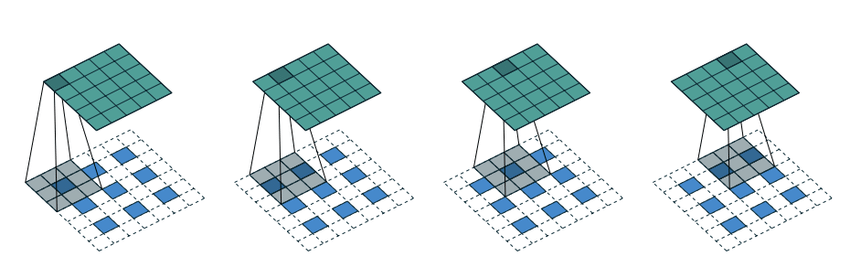

**Transposed Convolution**

We have a classic Conv layer. We fix the kernel spatial dimensions, the stride $S$ ($S>=1$), the padding, ... . This convolution can be represented by the application of a matrix $M$ on the input for getting the output: $M$ is called convolutional matrix. 

Basically, we are flattening the convolution (it is like applying a Dense layer instead of the Conv layer). The number of inputs is $I = w_{in}*h_{in}*c_{in}$. The number of outputs is $O = w_{out}*h_{out}*c_{out}$. Therefore, the matrix $M$ is a matrix $OxI$. 

By applying $M$ on the input, we are transforming $I$ into $O$. If $S>1$, we are decreasing the spatial dimensions.

We could apply the matrix $M$ in the transposed way. Instead of applying $M$, we apply $M^T$. In this way, if $S>1$, we are increasing the spatial dimensions. **TRANSPOSED CONVOLUTION**.

To sum up. We have defined a Conv layer: kernel size, stride, padding, ... . We can apply this convolution in two ways:
- Normal way. If $S>1$, we are decreasing the spatial dimensions. The bigger $S$, the bigger the decreasing.
- Transposed way. If $S>1$, we are increasing the spatial dimensions. The bigger $S$, the bigger the increasing.

(If $S=1$, no difference between normal way and transposed way).

It is important to notice that in this point of view we can define a Conv layer only in the classic way, with a stride which is an integer $S>=1$. It is not allowed to use a sub-unitarian stride $S<1$.

**Two equivalent points of view**

The two following points of view are equivalent.
1. Classic convolution with sub-unitarian stride $0<S<1$.
2. Transposed convolution with integer $S=1$.

A classic conv with sub-unitarian stride $1/S$ (e.g. $1/2$) is equivalent to transposed convolution with integer stride $S$ (e.g. $2$).

The main point of view is the second one. Transposed convolution.

In the Transposed conv point of view, we can have only an integer stride. Both in the classic Conv and in the Transposed conv, we can have only an integer stride. No sub-unitarian stride.

**Implementation in keras**

In keras this is implemented with the second point of view: Transposed convolution.

In [ ]:
from tensorflow.keras.layers import Conv2DTranspose

In [ ]:
x = Conv2DTranspose(filters=..., kernel_size=..., strides=..., padding=...)(x)

**Why are we interested in increasing the spatial dimensions**

Typically, we are interested in decreasing the spatial dimensions. However, there are situations in which we can be interested in increasing the spatial dimensions.

For example, in the widespread Autoencoder architecture. In the encoder part, we decrease the spatial dimensions for producing a compressed representation of the input. In the decoder part, we want to increase the spatial dimensions, for reaching the same size of the very input of the NN.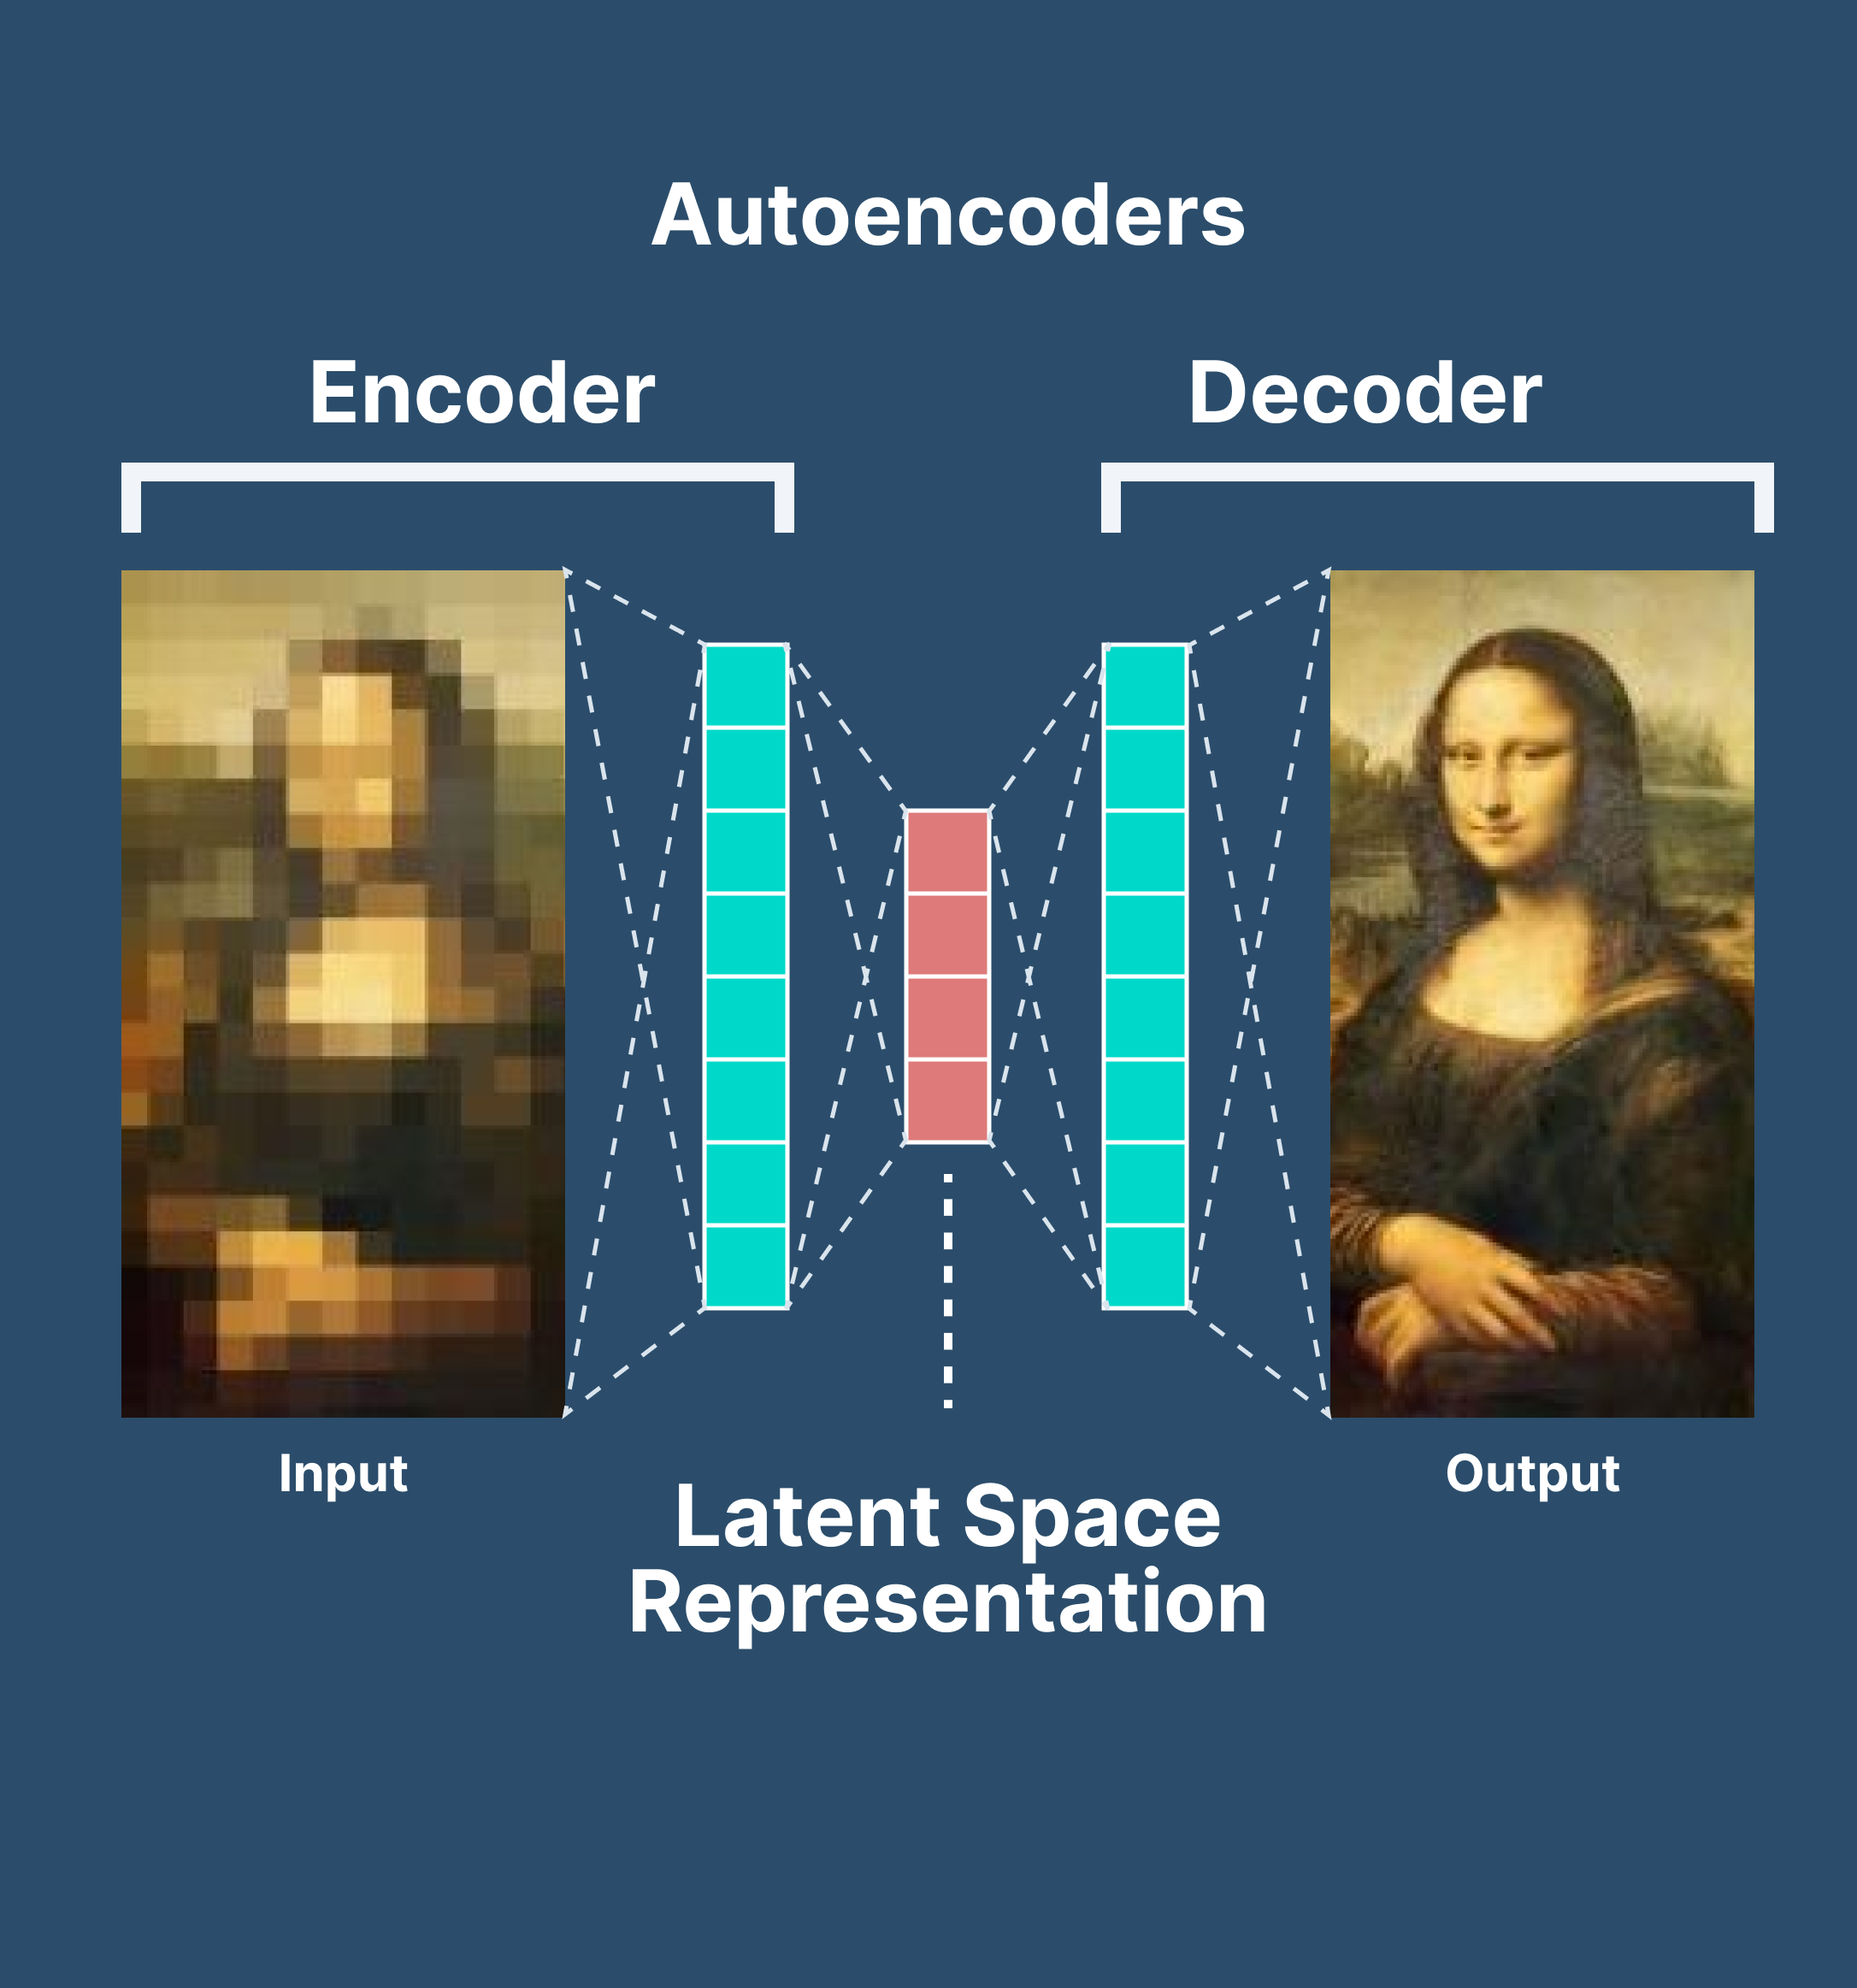

We find this same basic structure also in the very popular U-net NN.

## DILATED CONVOLUTION

If we take an hand-designed kernel with a lot of $0$, such as $\begin{bmatrix}
    0       & -1 & 2  \\
    0       & 0 & 0  \\
    0       & 1 & 0 
\end{bmatrix}$, it does not make sense to have the $0$. It would be the same to have holes in the kernel.

In our Conv layer, having $0$ values or having holes is the same: we are not considering those input values. However, a kernel with holes is easier to learn. Less weigths.

A dilated convolution is a Conv layer whose kernel has holes. 

Basically, we are expanding the kernel. We are expanding the kernel, by inflating it with holes.

Whi expansion is regulated by a **dilation rate**. Dilation rate $2$ -> we are expanding the kernel by $2$.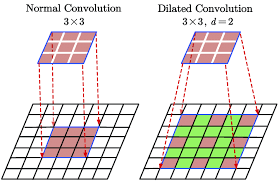

**Dilated conv and Transposed conv**

We don't have to confuse Dilated Conv and Transposed Conv.
- Dilated Conv: we are expanding the kernel.
- Transposed Conv: we are expanding the input.

**Why is dilated conv interesting?**

- A lot of difference situations in which we don't want to take into account all the pixels, but only the pixels at certain positions.
- From a practical point of view, it allows us to enlarge the receptive field but without increasing the number of parameters and without changing the input spatial dimensions. Since now we have enlarged the receptive field by decreasing the spatial dimensions (by means of a non-unitarian stride or MaxPooling): with dilated conv we enlarge the receptive field without modifying the spatial dimensions. The higher is the dilation rate, the bigger is the receptive field.

**Implementation in keras**

In keras a `Conv2D` layer has an optional argument called `dilation_rate`. 

In [ ]:
x = Conv2D(..., dilation_rate=(2,2))(x)  # We specify the dilation rate in both dimensions